In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
import os

import sklearn

import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd

np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

print('Tf version: ', tf.__version__)
print('K version: ', keras.__version__)

Tf version:  2.1.0
K version:  2.2.4-tf


## DATA

In [3]:
from tensorflow.keras.datasets import cifar10

(x_train,_), (x_test,_) = cifar10.load_data()

print(x_train.shape)

170500096/170498071 [==============================] - 6s 0us/step
(50000, 32, 32, 3)


In [0]:
x_train = x_train.astype(np.float32)/255.
x_test = x_test.astype(np.float32)/255. 

In [0]:
# import tf keras 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, Input, Reshape, Flatten


## VAE

In [0]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var/2) + mean

In [0]:
import tensorflow.keras.backend as K
from tensorflow.keras.layers import LeakyReLU

In [0]:
K.clear_session()

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 32


# functional API

# input layer
inputs = Input(shape=[32, 32, 3])
# flatten input
z = Flatten()(inputs)
# Dense 1
z = Dense(150, activation='selu')(z)
# LeakyRelu
# z = LeakyReLU()(z)
# Dense 2
z = Dense(100, activation='selu')(z)
# LeakyRelu
# z = LeakyReLU()(z)

# split into 'codings_mean' and 'codings_log_var'
codings_mean = Dense(codings_size)(z)
codings_log_var = Dense(codings_size)(z)

codings = Sampling()([codings_mean, codings_log_var])

# variational encoder
variational_encoder = Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

# decoder
decoder_inputs = Input(shape=[codings_size])
# Dense 1
x = Dense(100, activation='selu')(decoder_inputs)
# LeakyRelu
# x = LeakyReLU()(x)
# Dense 2
x = Dense(150, activation='selu')(x)
# LeakyRelu
# x = LeakyReLU()(x)
# Dense 3
x = Dense(32 * 32 * 3, activation='sigmoid')(x)
# Reshape into 32 * 32
outputs = Reshape(target_shape=[32, 32, 3])(x)

# variational decoder
variational_decoder = Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)

# variational auto-encoder
variational_ae = Model(inputs=[inputs], outputs=[reconstructions])



In [0]:
# Latent Loss

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)

variational_ae.add_loss(K.mean(latent_loss)/3072.)


In [0]:
# compile

variational_ae.compile(loss='binary_crossentropy', 
                       optimizer=tf.keras.optimizers.RMSprop())

In [12]:
# train

history = variational_ae.fit(x_train, x_train,  epochs=15, batch_size=128, validation_data=(x_test, x_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 7s 132us/sample - loss: 0.8677 - val_loss: 0.6389
Epoch 2/15
50000/50000 [==============================] - 4s 74us/sample - loss: 0.6308 - val_loss: 0.6271
Epoch 3/15
50000/50000 [==============================] - 4s 73us/sample - loss: 0.6225 - val_loss: 0.6191
Epoch 4/15
50000/50000 [==============================] - 4s 72us/sample - loss: 0.6182 - val_loss: 0.6193
Epoch 5/15
50000/50000 [==============================] - 4s 72us/sample - loss: 0.6153 - val_loss: 0.6150
Epoch 6/15
50000/50000 [==============================] - 4s 73us/sample - loss: 0.6134 - val_loss: 0.6130
Epoch 7/15
50000/50000 [==============================] - 4s 74us/sample - loss: 0.6120 - val_loss: 0.6116
Epoch 8/15
50000/50000 [==============================] - 4s 73us/sample - loss: 0.6107 - val_loss: 0.6096
Epoch 9/15
50000/50000 [==============================] - 4s 71us/sample - loss: 0.6099 - val

In [13]:
variational_ae.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
model (Model)                   [(None, 32), (None,  482514      input_1[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 32, 32, 3)    482322      model[1][2]                      
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3072)         0           input_1[0][0]                    
____________________________________________________________________________________________

In [0]:
# RECONSTRUCTIONS Utility function

def plot_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.gray()
plt.show()

In [0]:
def show_reconstructions(model, images=x_test, n_images=10):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
plt.show()

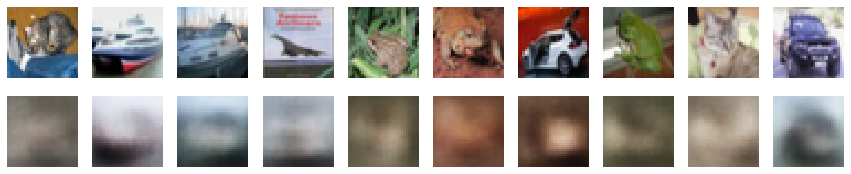

In [16]:
show_reconstructions(variational_ae)
plt.show()

In [0]:
ae_images = variational_ae.predict(x_test)

In [18]:
ae_images.shape


(10000, 32, 32, 3)

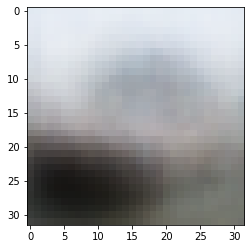

In [19]:
plt.imshow(ae_images[1])


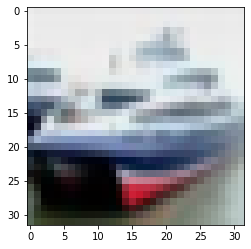

In [20]:
plt.imshow(x_test[1])

### Codings

In [0]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()

In [22]:
images.shape

(12, 32, 32, 3)

In [0]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

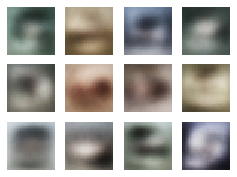

In [24]:
plot_multiple_images(images, 4)